# 5 Transfer learning

Total run time ~30 min.

### 1. Import dependencies

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm.notebook import trange, tqdm
from PIL import Image

In [3]:
import datetime
currentDT = datetime.datetime.now()
print (str(currentDT))

2020-05-20 10:16:06.185499


In [4]:
torch.__version__

'1.4.0'

### 2. Create PyTorch data generators

In [5]:
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

In [8]:
# define dataloader parameters
batch_size = 64
num_workers_train = 2
num_workers_validation = 4
num_workers_test = 4
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
data_transform = transforms.Compose([
        transforms.Resize((224,224)),
#        transforms.Grayscale(1),
        transforms.RandomApply([
            transforms.RandomAffine(0, translate=(0.2, 0.2), resample=Image.BICUBIC),
            transforms.RandomAffine(0, shear=20, resample=Image.BICUBIC),
            transforms.RandomAffine(0, scale=(0.8, 1.2), resample=Image.BICUBIC)
        ]), 
#        transforms.RandomRotation(15),
        transforms.ToTensor(),
        normalize
])

data_transform_test = transforms.Compose([
        transforms.Resize((224,224)),
#        transforms.Grayscale(1),
        transforms.ToTensor(),
        normalize
])

image_datasets = {
    'train':
        datasets.ImageFolder('./source_data_2/train/', data_transform),
    'validation': 
        datasets.ImageFolder('./source_data_2/valid/', data_transform),
    'test': 
        datasets.ImageFolder('./source_data_2/test/', data_transform_test)
}

a = torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=batch_size,
                                shuffle=True, num_workers=num_workers_train)
b = torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=batch_size,
                                shuffle=False, num_workers=num_workers_validation)
c = torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=batch_size,
                                shuffle=False, num_workers=num_workers_test)

dataloaders = {
    'train':
    WrappedDataLoader(a, to_device),
    'validation':
    WrappedDataLoader(b, to_device),
    'test':
    WrappedDataLoader(c, to_device)
}

In [9]:
#calculate sample weights
#train_size = datasize = len(image_datasets['train'])
train_size = 43 * 15000

def get_weighted_loader():
    class_sample_count = pd.read_csv('sign_count.csv')['count'].to_numpy()
    class_weights = 1 / class_sample_count
    class_id=0
    sample_weights = list()
    for class_weight in class_weights:
        sample_weights += ([class_weight] * class_sample_count[class_id])
        class_id += 1

    #replace train dataset
    samp = sampler.WeightedRandomSampler(sample_weights, train_size)
    a = torch.utils.data.DataLoader(image_datasets['train'],
                                    batch_size=batch_size,
                                    num_workers=num_workers_train, sampler=samp)
    return WrappedDataLoader(a, to_device)

dataloaders['train'] = get_weighted_loader()

### Training and evaluation source code

In [10]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            datasize = len(image_datasets[phase])
            if phase == 'train':
                datasize = train_size
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            train_loss = 0.0
            i = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                                

                epoch_loss = running_loss / datasize
                epoch_acc = running_corrects.float() / datasize
                train_loss += loss.item()
                if i % 500 == 499:
                    print('phase: {}, batch: {}, loss: {:.4f}, train_loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                                        i+1,
                                                                        epoch_loss.item(),
                                                                        train_loss / 500,
                                                                        epoch_acc.item()))
                    train_loss = 0.0
                i += 1


            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss.item(),
                                                        epoch_acc.item()))
    return model

In [11]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)


In [12]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)



In [13]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

### 3. Downlaod pre-trained model and adopt classifier 

In [14]:
model = models.resnet18(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
#model.fc = nn.Sequential(
#               nn.Linear(2048, 128),
#               nn.ReLU(inplace=True),
#               nn.Linear(128, 43)).to(device)

for param in model.parameters():
    param.requires_grad = False   
model.fc = nn.Linear(512, 43).to(device)

In [17]:
# applies weights to fully connected layer
def weights_init_normal(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        # get number of inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

# Initialize classifier
weights_init_normal(model.fc)

In [18]:
torch.save(model.state_dict(), 'res_18.start')
#model.load_state_dict(torch.load('res_18.start'))

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

### 4. Train the model

In [20]:
%%time
#model.load_state_dict(torch.load('res_18.pre-trained_1'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = train_model(model, criterion, optimizer, num_epochs=4)
evaluate(model, criterion, dataloaders['test'])

Epoch 1/4
----------
phase: train, batch: 500, loss: 0.0944, train_loss: 1.9029, acc: 0.0243
phase: train, batch: 1000, loss: 0.1477, train_loss: 1.0735, acc: 0.0585
phase: train, batch: 1500, loss: 0.1922, train_loss: 0.8984, acc: 0.0947
phase: train, batch: 2000, loss: 0.2323, train_loss: 0.8075, acc: 0.1321
phase: train, batch: 2500, loss: 0.2693, train_loss: 0.7451, acc: 0.1703
phase: train, batch: 3000, loss: 0.3045, train_loss: 0.7098, acc: 0.2089
phase: train, batch: 3500, loss: 0.3381, train_loss: 0.6775, acc: 0.2478
phase: train, batch: 4000, loss: 0.3701, train_loss: 0.6460, acc: 0.2871
phase: train, batch: 4500, loss: 0.4019, train_loss: 0.6404, acc: 0.3265
phase: train, batch: 5000, loss: 0.4323, train_loss: 0.6115, acc: 0.3662
phase: train, batch: 5500, loss: 0.4622, train_loss: 0.6027, acc: 0.4062
phase: train, batch: 6000, loss: 0.4918, train_loss: 0.5974, acc: 0.4462
phase: train, batch: 6500, loss: 0.5214, train_loss: 0.5958, acc: 0.4861
phase: train, batch: 7000, loss

In [21]:
torch.save(model.state_dict(), 'res_18.pre-trained_2')

In [ ]:
%%time
#model.load_state_dict(torch.load('res_18.pre-trained_1'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
model = train_model(model, criterion, optimizer, num_epochs=1)
evaluate(model, criterion, dataloaders['test'])

Epoch 1/1
----------
phase: train, batch: 500, loss: 0.0220, train_loss: 0.4434, acc: 0.0422
phase: train, batch: 1000, loss: 0.0435, train_loss: 0.4329, acc: 0.0846
phase: train, batch: 1500, loss: 0.0643, train_loss: 0.4192, acc: 0.1271
phase: train, batch: 2000, loss: 0.0852, train_loss: 0.4213, acc: 0.1697
phase: train, batch: 2500, loss: 0.1064, train_loss: 0.4282, acc: 0.2122
phase: train, batch: 3000, loss: 0.1273, train_loss: 0.4214, acc: 0.2548
phase: train, batch: 3500, loss: 0.1487, train_loss: 0.4300, acc: 0.2973
phase: train, batch: 4000, loss: 0.1693, train_loss: 0.4169, acc: 0.3399
phase: train, batch: 4500, loss: 0.1905, train_loss: 0.4263, acc: 0.3824
phase: train, batch: 5000, loss: 0.2110, train_loss: 0.4126, acc: 0.4251
phase: train, batch: 5500, loss: 0.2319, train_loss: 0.4220, acc: 0.4677
phase: train, batch: 6000, loss: 0.2530, train_loss: 0.4251, acc: 0.5102
phase: train, batch: 6500, loss: 0.2744, train_loss: 0.4311, acc: 0.5526
phase: train, batch: 7000, loss

In [23]:
torch.save(model.state_dict(), 'res_18.pre-trained_3')
#model.load_state_dict(torch.load('model.pre-trained_3'))

In [24]:
%%time
evaluate(model, criterion, dataloaders['test'])

Test loss: 0.992744	Test accruacy: 71.774%
CPU times: user 17.8 s, sys: 6.22 s, total: 24 s
Wall time: 24.4 s


### 5. Make predictions on sample test images¶

In [25]:
validation_img_paths = ["./source_data_2/test/00/00243.ppm",
                        "./source_data_2/test/01/00001.ppm",
                        "./source_data_2/test/02/00034.ppm"]

img_list = [Image.open(img_path) for img_path in validation_img_paths]
validation_classes = [0, 1, 2]

In [26]:
validation_batch = torch.stack([data_transform(img).to(device)
                                for img in img_list])

In [27]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

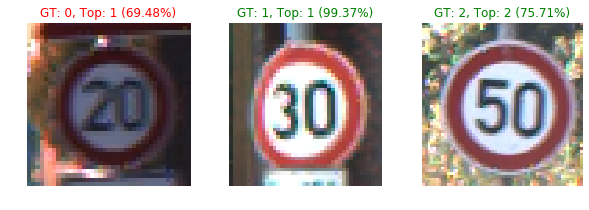

In [28]:
fig, axs = plt.subplots(1, len(img_list), figsize=(10, 3))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    maxConfidenceValue = np.amax(pred_probs[i,:])
    maxConfidenceClass = np.where(pred_probs[i,:] == maxConfidenceValue)[0][0]
    color = 'green'
    if maxConfidenceClass != validation_classes[i]:
        color = 'red'
    ax.set_title("GT: {}, Top: {} ({:.2f}%)".format(validation_classes[i], maxConfidenceClass, maxConfidenceValue*100), color=color)
    ax.imshow(img)

In [ ]:
currentDT = datetime.datetime.now()
print (str(currentDT))